## **Assignment 6 - Exercise 1 - Text Classification with Transformers**

<b><u>Contributor</u></b>: Dimitris Vougioukos - f3352411

The following is the implementation of the exercise 1 of the sixth assignment of the Text Analytics course on text classification with Transformers

### **Exercise 1**

Import required libraries

In [1]:
# Downloading libraries
!pip install datasets

# Importing required libraries
import random
import nltk
import numpy as np
import os
import matplotlib.pyplot as plt
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from datasets import Dataset
from functools import partial
from peft import LoraConfig, get_peft_model
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    classification_report,
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)


# Downloading NLTK dataset
nltk.download("movie_reviews")

# Disabling weights and biases
os.environ["WANDB_MODE"] = "disabled"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


Explore the `movie_reviews` dataset

In [2]:
# Getting all the file ids
file_ids = movie_reviews.fileids()

print(f"Five random file ids of the dataset:\n {random.sample(file_ids, 5)}\n")

# Getting the distinct classes
categories = movie_reviews.categories()

print(f"The distinct classes of the reviews:\n {categories} \n")
print(f"The number of positive reviews is: {len(movie_reviews.fileids('pos'))} \n")
print(f"The number of negative reviews is: {len(movie_reviews.fileids('neg'))}")

Five random file ids of the dataset:
 ['neg/cv148_18084.txt', 'pos/cv041_21113.txt', 'neg/cv210_9557.txt', 'pos/cv585_22496.txt', 'neg/cv223_28923.txt']

The distinct classes of the reviews:
 ['neg', 'pos'] 

The number of positive reviews is: 1000 

The number of negative reviews is: 1000


Retrieve the raw text of each review and its corresponding category

In [3]:
# Initializing two lists to keep the raw text of each review and its category
reviews_text = []
reviews_category = []

# Iterating over the review categories
for category in categories:

    # Iterating over the file ids of the current category
    for file_id in movie_reviews.fileids(category):

        # Updating the lists
        reviews_text.append(movie_reviews.raw(file_id))
        reviews_category.append(1 if category == "pos" else 0)

Split dataset into training, validation and test datasets

In [4]:
# Splitting the dataset into training and test datasets
training_reviews, test_reviews, training_categories, test_categories = (
    train_test_split(
        reviews_text,
        reviews_category,
        test_size=0.2,
        random_state=42,
        stratify=reviews_category,
    )
)

# Splitting the training dataset into training and development datasets
training_reviews, validation_reviews, training_categories, validation_categories = (
    train_test_split(
        training_reviews,
        training_categories,
        test_size=0.3,
        random_state=42,
        stratify=training_categories,
    )
)

print(f"The number of reviews in the training dataset is: {len(training_reviews)}")
print(f"The number of reviews in the validation dataset is: {len(validation_reviews)}")
print(f"The number of reviews in the test dataset is: {len(test_reviews)}")

The number of reviews in the training dataset is: 1120
The number of reviews in the validation dataset is: 480
The number of reviews in the test dataset is: 400


Convert datasets to Hugging Face dataset format

In [5]:
# Converting

training_dataset = Dataset.from_dict(
    {"text": training_reviews, "label": training_categories}
)
validation_dataset = Dataset.from_dict(
    {"text": validation_reviews, "label": validation_categories}
)
test_dataset = Dataset.from_dict({"text": test_reviews, "label": test_categories})

Define a function to tokenize the reviews using a BERT tokenizer

In [6]:
def tokenize_reviews(reviews_dataset, bert_tokenizer):
    """
    This function is used to tokenize the reviews using a BERT tokenizer.

    :param reviews_dataset: A list of reviews
    :param bert_tokenizer: A BERT tokenizer
    :return: A list of tokenized reviews
    """

    # Tokenizing
    tokenized_reviews = bert_tokenizer(
        reviews_dataset["text"],
        padding="max_length",
        truncation=True,
        max_length=300,
    )

    return tokenized_reviews

Define a function for setting a LoRA configuration for efficient fine tuning processing

In [7]:
def configure_lora(r=4, lora_alpha=16, lora_dropout=0.1):
    """
    This function is used to set a LoRA configuration.

    :param r: The rank of the LoRA weights
    :param lora_alpha: The scaling factor for the LoRA weights
    :param lora_dropout: The dropout rate for the LoRA weights
    :return: A LoraConfig object
    """

    # Defining LoRA configuration
    lora_configuration = LoraConfig(
        r=r,
        lora_alpha=lora_alpha,
        target_modules=["query", "value"],
        lora_dropout=lora_dropout,
        task_type="SEQ_CLS",
    )

    return lora_configuration

Define a function for training a BERT model

In [ ]:
def train_bert_model(bert_model, bert_model_name, training_dataset, validation_dataset):
    """
    This function is used to train a BERT model for binary classification.

    :param bert_model: A BERT model
    :param bert_model_name: The name of the BERT model
    :param training_dataset: A Hugging Face dataset for training
    :param validation_dataset: A Hugging Face dataset for validation
    :return: A Trainer object
    """

    # Defining the training arguments
    training_arguments = TrainingArguments(
        output_dir=f"./{bert_model_name}_results",
        learning_rate=1e-4,
        eval_strategy="epoch",
        save_strategy="epoch",
        weight_decay=0.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        logging_strategy="epoch",
        num_train_epochs=5,
        load_best_model_at_end=True,
        metric_for_best_model="loss",
        greater_is_better=False,
        report_to="none",
    )

    # Defining the Trainer
    trainer = Trainer(
        bert_model,
        training_arguments,
        train_dataset=training_dataset,
        eval_dataset=validation_dataset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    # Training the model
    trainer.train()

    return trainer

Define a function for collecting the various losses across epochs after training a BERT model

In [9]:
def collect_losses(trainer):
    """
    This function is used to collect the training and validation losses
    from a Trainer object.

    :param trainer: A Trainer object
    :return: The training and validation losses
    """

    # Setting two lists keeping the training and validation losses
    training_losses, validation_losses = [], []

    # Iterating over the logs
    for log in trainer.state.log_history:

        # Checking for training loss
        if "loss" in log:

            # Updating
            training_losses.append(log["loss"])

        # Checking for validation loss
        if "eval_loss" in log:

            # Updating
            validation_losses.append(log["eval_loss"])

    return training_losses, validation_losses

Train BERT models

In [10]:
# Setting the BERT models to test
bert_models_names = [
    "distilroberta-base",
    "siebert/sentiment-roberta-large-english",
    "bert-base-uncased",
]

# Setting a dictionary for keeping info about the models after training
bert_models_info = {}

# Iterating over the BERT models
for bert_model_name in bert_models_names:

    print(f"\n\033[1;4m{bert_model_name}\033[0m\n")

    # Loading the relevant BERT tokenizer
    bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

    # Creating a partial function to pass parameters to the 'tokenize' function
    pass_parameters = partial(tokenize_reviews, bert_tokenizer=bert_tokenizer)

    # Tokenizing the reviews
    tokenized_training_dataset = training_dataset.map(pass_parameters, batched=True)
    tokenized_validation_dataset = validation_dataset.map(pass_parameters, batched=True)

    # Converting the datasets to PyTorch tensors for efficient processing
    tokenized_training_dataset.set_format(
        type="torch", columns=["input_ids", "attention_mask", "label"]
    )
    tokenized_validation_dataset.set_format(
        type="torch", columns=["input_ids", "attention_mask", "label"]
    )

    # Loading the pre-trained BERT model for binary classification
    bert_model = AutoModelForSequenceClassification.from_pretrained(
        bert_model_name, num_labels=2
    )

    # Counting the model's total parameters
    total_parameters = sum(parameter.numel() for parameter in bert_model.parameters())

    # Counting the model's trainable parameters
    total_trainable_parameters = sum(
        parameter.numel()
        for parameter in bert_model.parameters()
        if parameter.requires_grad
    )

    print(
        f"\nThe total parameters of the '{bert_model_name}' model is: {total_parameters}"
    )
    print(
        f"The trainable parameters of the '{bert_model_name}' model is: {total_trainable_parameters}\n"
    )

    # Appling LoRA to the BERT model
    bert_model = get_peft_model(bert_model, configure_lora())

    # Printing the final trainable parameters after using LoRA
    bert_model.print_trainable_parameters()

    print(f"\nTraining...")

    # Training
    trainer = train_bert_model(
        bert_model, bert_model_name, tokenized_training_dataset, tokenized_validation_dataset
    )

    # Collecting the losses
    training_losses, validation_losses = collect_losses(trainer)

    # Updating
    bert_models_info[bert_model_name] = {
        "training_losses": training_losses,
        "validation_losses": validation_losses,
        "trainer": trainer,
        "tokenizer": bert_tokenizer,
    }


distilroberta-base



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1120 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



The total parameters of the 'distilroberta-base' model is: 82119938
The trainable parameters of the 'distilroberta-base' model is: 82119938

trainable params: 665,858 || all params: 82,785,796 || trainable%: 0.8043

Training...


Epoch,Training Loss,Validation Loss
1,0.691700,0.679433
2,0.631000,0.523171
3,0.523200,0.491170
4,0.473400,0.498599
5,0.458200,0.477722



siebert/sentiment-roberta-large-english



tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/1120 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]


The total parameters of the 'siebert/sentiment-roberta-large-english' model is: 355361794
The trainable parameters of the 'siebert/sentiment-roberta-large-english' model is: 355361794

trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049

Training...


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.200600,0.229041
2,0.162300,0.222176
3,0.154900,0.222273
4,0.136100,0.249672



bert-base-uncased



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1120 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



The total parameters of the 'bert-base-uncased' model is: 109483778
The trainable parameters of the 'bert-base-uncased' model is: 109483778

trainable params: 148,994 || all params: 109,632,772 || trainable%: 0.1359

Training...


Epoch,Training Loss,Validation Loss
1,0.710900,0.695681
2,0.689300,0.686439
3,0.681300,0.675575
4,0.672800,0.672244
5,0.661700,0.667938


Show loss in training and validation data at all epochs for all BERT models

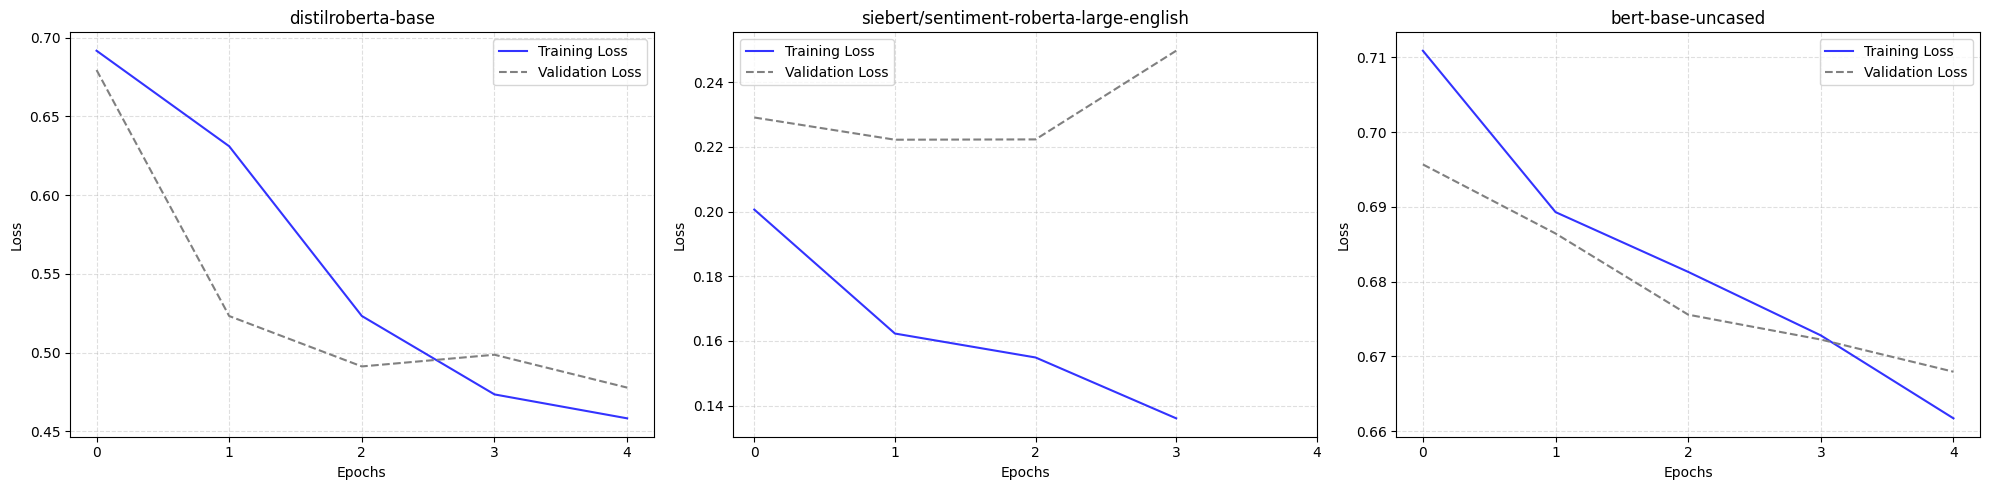

In [ ]:
# Creating a figure with 1 rows and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterating over the training results of the models
for index, (key, value) in enumerate(bert_models_info.items()):

    # Getting the current plot
    ax = axes[index]

    # Plotting the lines
    ax.plot(
        value["training_losses"],
        label="Training Loss",
        linestyle="-",
        alpha=0.8,
        color="blue",
    )
    ax.plot(
        value["validation_losses"],
        label="Validation Loss",
        linestyle="--",
        color="grey",
    )

    # Setting plot parameters
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_xticks(list(range(5)))
    ax.set_title(key)
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.8, alpha=0.4)

# Adjusting the layout and showing the plots
plt.tight_layout()
plt.show()

Get the BERT model with the lowest validation loss

In [13]:
# Selecting the model with the lowest validation loss
best_bert_model_name = min(
    bert_models_info,
    key=lambda model: min(bert_models_info[model]["validation_losses"]),
)

print(f"Best BERT model: {best_bert_model_name}")

# Retrieving the relevant trainer and tokenizer
best_trainer = bert_models_info[best_bert_model_name]["trainer"]
best_tokenizer = bert_models_info[best_bert_model_name]["tokenizer"]

Best BERT model: siebert/sentiment-roberta-large-english


After testing multiple BERT models and analyzing the training loss and validation loss curves according to the above plots, the 'siebert/sentiment-roberta-large-english' model emerged as the best model, achieving a validation loss of 0.222176 at epoch 2.

Tokenize the datasets based on the best BERT model's tokenizer

In [15]:
# Creating a partial function to pass parameters to the 'tokenize' function
pass_parameters = partial(tokenize_reviews, bert_tokenizer=best_tokenizer)

# Tokenizing the reviews
training_dataset = training_dataset.map(pass_parameters, batched=True)
validation_dataset = validation_dataset.map(pass_parameters, batched=True)
test_dataset = test_dataset.map(pass_parameters, batched=True)

# Converting the datasets to PyTorch tensors for efficient processing
training_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "label"]
)
validation_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "label"]
)
test_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "label"]
)

Map:   0%|          | 0/1120 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Make predictions on all datasets (training, validation, test) using the best model

In [16]:
# Making predictions for all datasets
training_predictions = best_trainer.predict(training_dataset)
validation_predictions = best_trainer.predict(validation_dataset)
test_predictions = best_trainer.predict(test_dataset)

# Getting the logits
training_logits = training_predictions.predictions
validation_logits = validation_predictions.predictions
test_logits = test_predictions.predictions

# Getting the relevant probabilities using softmax
training_predicted_probs = np.exp(training_logits) / np.sum(
    np.exp(training_logits), axis=1, keepdims=True
)
validation_predicted_probs = np.exp(validation_logits) / np.sum(
    np.exp(validation_logits), axis=1, keepdims=True
)
test_predicted_probs = np.exp(test_logits) / np.sum(
    np.exp(test_logits), axis=1, keepdims=True
)

# Getting the predicted labels
training_predicted_labels = np.argmax(training_predicted_probs, axis=1)
validation_predicted_labels = np.argmax(validation_predicted_probs, axis=1)
test_predicted_labels = np.argmax(test_predicted_probs, axis=1)

Define a function to compute the classification scores of a BERT classifier

In [17]:
def compute_classification_scores(
    ground_truth, category_predictions, positive_probs, negative_probs
):
    """
    This function is used to compute the classification scores of a
    classifier on a given dataset.

    :param ground_truth: The actual categories
    :param category_predictions: The predicted categories
    :param positive_probs: The positive predicted probabilities
    :param negative_probs: The negative predicted probabilities
    :return: The classification scores
    """

    # Computing the precision, recall and f1 scores
    classification_scores = classification_report(
        ground_truth,
        category_predictions,
        target_names=["neg", "pos"],
        output_dict=True,
        zero_division=0,
    )

    # Computing the precision-recall auc score for "pos" category
    precision_pos, recall_pos, _ = precision_recall_curve(ground_truth, positive_probs)
    pr_auc_pos = auc(recall_pos, precision_pos)

    # Updating the scores
    classification_scores["pos"]["precision-recall-auc"] = pr_auc_pos

    # Computing the precision-recall auc score for "neg" category
    precision_neg, recall_neg, _ = precision_recall_curve(
        [1 - value for value in ground_truth],
        negative_probs,
    )
    pr_auc_neg = auc(recall_neg, precision_neg)

    # Updating the scores
    classification_scores["neg"]["precision-recall-auc"] = pr_auc_neg

    # Computing the macro-average for the precision-recall auc score
    classification_scores["macro avg"]["precision-recall-auc"] = (
        pr_auc_pos + pr_auc_neg
    ) / 2

    return classification_scores

Compute the classification scores of the best BERT model on all datasets

In [18]:
# Computing the classification scores

training_classification_scores = compute_classification_scores(
    training_categories,
    training_predicted_labels.tolist(),
    training_predicted_probs[:, 1].tolist(),
    training_predicted_probs[:, 0].tolist(),
)
validation_classification_scores = compute_classification_scores(
    validation_categories,
    validation_predicted_labels.tolist(),
    validation_predicted_probs[:, 1].tolist(),
    validation_predicted_probs[:, 0].tolist(),
)
test_classification_scores = compute_classification_scores(
    test_categories,
    test_predicted_labels.tolist(),
    test_predicted_probs[:, 1].tolist(),
    test_predicted_probs[:, 0].tolist(),
)

Display the classification scores of the model on all datasets (training, validation, test)

In [19]:
# Creating the first level of headers
table_headers_level_1 = [
    "",
    "\033[1mTraining Dataset\033[0m",
    "",
    "",
    "",
    "\033[1mValidation Dataset\033[0m",
    "",
    "",
    "",
    "\033[1mTest Dataset\033[0m",
    "",
    "",
    "",
]

# Creating the second level of headers
table_headers_level_2 = [
    "",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
]

# Creating the table values
table_data = [
    [
        "neg",
        round(training_classification_scores["neg"]["precision"], 4),
        round(training_classification_scores["neg"]["recall"], 4),
        round(training_classification_scores["neg"]["f1-score"], 4),
        round(training_classification_scores["neg"]["precision-recall-auc"], 4),
        round(validation_classification_scores["neg"]["precision"], 4),
        round(validation_classification_scores["neg"]["recall"], 4),
        round(validation_classification_scores["neg"]["f1-score"], 4),
        round(validation_classification_scores["neg"]["precision-recall-auc"], 4),
        round(test_classification_scores["neg"]["precision"], 4),
        round(test_classification_scores["neg"]["recall"], 4),
        round(test_classification_scores["neg"]["f1-score"], 4),
        round(test_classification_scores["neg"]["precision-recall-auc"], 4),
    ],
    [
        "pos",
        round(training_classification_scores["pos"]["precision"], 4),
        round(training_classification_scores["pos"]["recall"], 4),
        round(training_classification_scores["pos"]["f1-score"], 4),
        round(training_classification_scores["pos"]["precision-recall-auc"], 4),
        round(validation_classification_scores["pos"]["precision"], 4),
        round(validation_classification_scores["pos"]["recall"], 4),
        round(validation_classification_scores["pos"]["f1-score"], 4),
        round(validation_classification_scores["pos"]["precision-recall-auc"], 4),
        round(test_classification_scores["pos"]["precision"], 4),
        round(test_classification_scores["pos"]["recall"], 4),
        round(test_classification_scores["pos"]["f1-score"], 4),
        round(test_classification_scores["pos"]["precision-recall-auc"], 4),
    ],
    [
        "macro-average",
        round(training_classification_scores["macro avg"]["precision"], 4),
        round(training_classification_scores["macro avg"]["recall"], 4),
        round(training_classification_scores["macro avg"]["f1-score"], 4),
        round(training_classification_scores["macro avg"]["precision-recall-auc"], 4),
        round(validation_classification_scores["macro avg"]["precision"], 4),
        round(validation_classification_scores["macro avg"]["recall"], 4),
        round(validation_classification_scores["macro avg"]["f1-score"], 4),
        round(validation_classification_scores["macro avg"]["precision-recall-auc"], 4),
        round(test_classification_scores["macro avg"]["precision"], 4),
        round(test_classification_scores["macro avg"]["recall"], 4),
        round(test_classification_scores["macro avg"]["f1-score"], 4),
        round(test_classification_scores["macro avg"]["precision-recall-auc"], 4),
    ],
]

# Showing the classification scores

print(f"\033[1m{'Classification Scores':^200}\033[0m")
print()
print(
    tabulate(
        [table_headers_level_2] + table_data,
        headers=table_headers_level_1,
        tablefmt="rounded_grid",
    )
)

                                                                                         Classification Scores                                                                                          

╭───────────────┬────────────────────┬────────┬──────────┬─────────────────────────────┬──────────────────────┬────────┬──────────┬─────────────────────────────┬────────────────┬────────┬──────────┬─────────────────────────────╮
│               │ Training Dataset   │        │          │                             │ Validation Dataset   │        │          │                             │ Test Dataset   │        │          │                             │
├───────────────┼────────────────────┼────────┼──────────┼─────────────────────────────┼──────────────────────┼────────┼──────────┼─────────────────────────────┼────────────────┼────────┼──────────┼─────────────────────────────┤
│               │ Precision          │ Recall │ f1-Score │ Precission-Recall AUC Score │ Precision            │